In [4]:
!python -m pip install --upgrade pip
!pip install --upgrade pip
!pip install gymnasium  
!pip install tensorflow  
!pip install numpy       
!pip install opencv-python  
!pip install matplotlib
!pip install streamlit

  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [5]:
# Importing the necessary libraries
import gymnasium as gym
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import cv2
import matplotlib.pyplot as plt
import streamlit as st
print("All libraries imported successfully!")

print("Gymnasium version:", gym.__version__)
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)


All libraries imported successfully!
Gymnasium version: 1.0.0
TensorFlow version: 2.18.0
NumPy version: 1.26.4
OpenCV version: 4.10.0


In [7]:
# Test environment (add this here)
try:
    env = gym.make('CarRacing-v3', render_mode='rgb_array')
    obs, info = env.reset()
    print("Environment initialized successfully with observation shape:", obs.shape)
    env.close()
except Exception as e:
    print(f"Error initializing the environment: {e}")

Environment initialized successfully with observation shape: (96, 96, 3)


In [8]:
# Define KLRegularizer class
class KLRegularizer(tf.keras.layers.Layer):
    def __init__(self, kl_tolerance, z_size):
        super(KLRegularizer, self).__init__()
        self.kl_tolerance = kl_tolerance
        self.z_size = z_size

    def call(self, inputs):
        mu, logvar = inputs
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))
        return tf.maximum(kl_loss, self.kl_tolerance)

In [9]:
# Importing necessary libraries
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape

# Building the VAE model within a class
class ConvVAE(object):
    def __init__(self, z_size=32, batch_size=1, learning_rate=0.0001,
                 kl_tolerance=0.5, is_training=False, reuse=False, gpu_mode=False):
        self.z_size = z_size
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.kl_tolerance = kl_tolerance
        self.is_training = is_training
        self.reuse = reuse

        # Build the model architecture
        self.build_vae_model()

    def build_vae_model(self):
        # Encoder
        self.inputs = tf.keras.Input(shape=(64, 64, 3))
        h = Conv2D(32, 4, strides=2, activation='relu', name='enc_conv1')(self.inputs)
        h = Conv2D(64, 4, strides=2, activation='relu', name='enc_conv2')(h)
        h = Conv2D(128, 4, strides=2, activation='relu', name='enc_conv3')(h)
        h = Conv2D(256, 4, strides=2, activation='relu', name='enc_conv4')(h)
        h = Flatten()(h)

        # Latent variables
        self.mu = Dense(self.z_size, name='enc_fc_mu')(h)
        self.logvar = Dense(self.z_size, name='enc_fc_logvar')(h)
        self.sigma = tf.keras.layers.Lambda(lambda x: tf.exp(x / 2.0))(self.logvar)
        self.epsilon = tf.keras.layers.Lambda(lambda x: tf.random.normal(tf.shape(x)))(self.mu)
        self.z = tf.keras.layers.Add()([self.mu, tf.keras.layers.Multiply()([self.sigma, self.epsilon])])

        # Decoder
        h = Dense(1024, name='dec_fc')(self.z)
        h = Reshape((1, 1, 1024))(h)
        h = Conv2DTranspose(128, 5, strides=2, activation='relu', name='dec_deconv1')(h)
        h = Conv2DTranspose(64, 5, strides=2, activation='relu', name='dec_deconv2')(h)
        h = Conv2DTranspose(32, 6, strides=2, activation='relu', name='dec_deconv3')(h)
        self.outputs = Conv2DTranspose(3, 6, strides=2, activation='sigmoid', name='dec_deconv4')(h)

        # KL Divergence Regularization Layer
        kl_layer = KLRegularizer(kl_tolerance=self.kl_tolerance, z_size=self.z_size)([self.mu, self.logvar])

        # Create the model
        self.vae = tf.keras.Model(self.inputs, self.outputs)

    def compile_vae_model(self):
        # Compile the Model
        self.vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                         loss='mse')

# Create an instance of ConvVAE and compile the model
vae_model = ConvVAE()
vae_model.compile_vae_model()


In [10]:
# Define mdn_loss function
def mdn_loss(y_true, y_pred):
    # Cast y_true and y_pred to float32 to ensure consistent data types
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Split y_pred into its components (logmix, mean, logstd)
    logmix, mean, logstd = tf.split(y_pred, num_or_size_splits=3, axis=-1)

    # Compute the loss components
    num_mixtures = 5  # Assuming num_mixtures = 5
    mean = tf.reshape(mean, (-1, tf.shape(mean)[1], tf.shape(mean)[2] // num_mixtures, num_mixtures))
    logstd = tf.reshape(logstd, (-1, tf.shape(logstd)[1], tf.shape(logstd)[2] // num_mixtures, num_mixtures))

    # Expand y_true to match the number of mixtures
    y_true = tf.expand_dims(y_true, axis=-1)

    logmix = tf.reshape(logmix, (-1, tf.shape(logmix)[1], tf.shape(mean)[2], num_mixtures))

    # Compute log likelihood of the data given the distribution
    logmix = logmix - tf.reduce_logsumexp(logmix, axis=-1, keepdims=True)
    logsqrtTwoPI = tf.cast(np.log(np.sqrt(2.0 * np.pi)), tf.float32)  # Ensure consistency with float32
    log_prob = -0.5 * tf.square((y_true - mean) / tf.exp(logstd)) - logstd - logsqrtTwoPI
    v = logmix + log_prob

    # Return negative log-likelihood
    return -tf.reduce_mean(tf.reduce_logsumexp(v, axis=-1))


In [11]:
class MDNRNN:
    def __init__(self, hps):
        self.hps = hps
        self.build_rnn_model()

    def build_rnn_model(self):
        # Define LSTM model using keras.layers
        self.inputs = tf.keras.Input(shape=(self.hps.max_seq_len, self.hps.input_seq_width))
        lstm_layer = LSTM(self.hps.rnn_size, return_sequences=True, name='RNN_Layer')(self.inputs)
        self.outputs = Dense(self.hps.output_seq_width * self.hps.num_mixture * 3, name='output')(lstm_layer)
        self.rnn = tf.keras.Model(self.inputs, self.outputs)

    def compile_model(self):
        # Compile the model using the external mdn_loss function
        self.rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.hps.learning_rate), loss=mdn_loss)

    def manual_train(self, x_train, y_train, epochs, batch_size):
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.hps.learning_rate)
        loss_fn = mdn_loss
        dataset_size = x_train.shape[0]
        steps_per_epoch = dataset_size // batch_size

        for epoch in range(epochs):
            tf.print(f"Epoch {epoch + 1}/{epochs}")

            indices = np.arange(dataset_size)
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]

            for step in range(steps_per_epoch):
                start_idx = step * batch_size
                end_idx = start_idx + batch_size
                x_batch = x_train[start_idx:end_idx]
                y_batch = y_train[start_idx:end_idx]

                with tf.GradientTape() as tape:
                    predictions = self.rnn(x_batch, training=True)
                    loss = loss_fn(y_batch, predictions)

                gradients = tape.gradient(loss, self.rnn.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.rnn.trainable_variables))

                if step % 10 == 0:
                    tf.print(f"Step {step}, Loss: ", loss)

In [12]:
# Define Hyperparameters
class HParams:
    def __init__(self):
        self.max_seq_len = 100
        self.input_seq_width = 160
        self.output_seq_width = 160
        self.rnn_size = 64
        self.num_mixture = 5
        self.learning_rate = 0.001
        self.batch_size = 16

# Set up hyperparameters
hps = HParams()
rnn_model = MDNRNN(hps)
rnn_model.compile_model()


In [13]:
# Example data (replace with real data)
x_train_rnn = np.random.rand(100, hps.max_seq_len, hps.input_seq_width).astype(np.float32)
y_train_rnn = np.random.rand(100, hps.max_seq_len, hps.output_seq_width).astype(np.float32)

# Manual training without tf.data.Dataset to avoid iteration-related issues
rnn_model.manual_train(x_train_rnn, y_train_rnn, epochs=10, batch_size=hps.batch_size)

Epoch 1/10
Step 0, Loss:  1.0828284
Epoch 2/10
Step 0, Loss:  0.843203485
Epoch 3/10
Step 0, Loss:  0.483626
Epoch 4/10
Step 0, Loss:  0.259130895
Epoch 5/10
Step 0, Loss:  0.224972039
Epoch 6/10
Step 0, Loss:  0.184814498
Epoch 7/10
Step 0, Loss:  0.169432461
Epoch 8/10
Step 0, Loss:  0.145182952
Epoch 9/10
Step 0, Loss:  0.124111071
Epoch 10/10
Step 0, Loss:  0.109072007


Environment initialized successfully. Observation shape: (96, 96, 3)
Environment reset successful. Observation shape: (96, 96, 3)


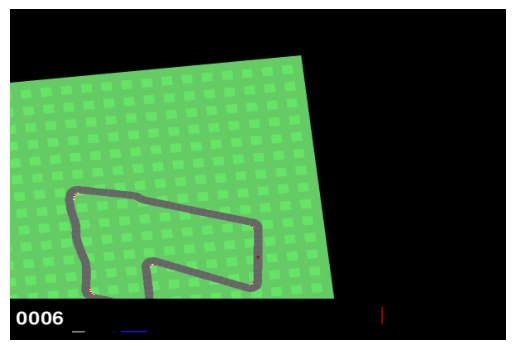

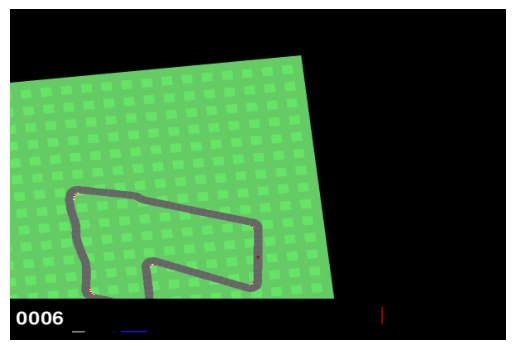

In [14]:
# Create the gym environment and render the initial frame
env = gym.make('CarRacing-v3', render_mode='rgb_array')
obs, _ = env.reset()
print("Environment initialized successfully. Observation shape:", obs.shape)
env.close()

# Reset environment and fetch the first observation
obs, info = env.reset()
print("Environment reset successful. Observation shape:", obs.shape)

# Example of deriving an action and stepping through the environment
action = np.array([0.0, 1.0, 0.0])  # Example action: no steering, full gas, no brake
obs, reward, terminated, truncated, info = env.step(action)
done = terminated or truncated

# Render the environment visually (instead of rgb_array)
frame = env.render()
plt.imshow(frame)
plt.axis('off')
from IPython.display import display
display(plt.gcf())


In [15]:
# Move to Streamlit (for deployment)
# Ensure that the environment runs seamlessly in Streamlit
# Define action from latent representation
def derive_action_from_latent(z):
    z = z.flatten()  # Make sure it's a 1D array
    steering = np.tanh(z[0])  # Steering is between -1 and 1
    gas = np.clip(z[1], 0, 1)  # Gas is between 0 and 1
    brake = np.clip(z[2], 0, 1)  # Brake is between 0 and 1
    return [steering, gas, brake]

# Placeholder for reward metrics
reward_chart = st.line_chart([])

2024-12-07 10:51:56.105 
  command:

    streamlit run D:\Anaconda\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [17]:
# Capture video output - captures the video during the gameplay
# Video made available to download on Streamlit
# AI Playing Function
def ai_play(env, vae_model):
    try:
        obs = env.reset()
        total_reward = 0
        reward_history = []

        # Set up the VideoWriter to save the video
        height, width, layers = env.render(mode='rgb_array').shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter('ai_play_output.mp4', fourcc, 20.0, (width, height))

        for steps in range(200):
            # Encode the observation using VAE
            z = vae_model.encode(obs)
            action = derive_action_from_latent(z)

            # Step in the environment
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            reward_history.append(total_reward)

            # Render the frame and save it to video
            frame = env.render(mode='rgb_array')
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

            # Update reward chart
            reward_chart.line_chart(reward_history)

            if done:
                break

        out.release()
        return total_reward
    finally:
        env.close()

# Human Playing Function with try...finally for safe cleanup
def human_play(env):
    try:
        obs = env.reset()
        total_reward_human = 0
        stframe = st.empty()

        # Set up the VideoWriter to save the video
        height, width, layers = env.render(mode='rgb_array').shape
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter('human_play_output.mp4', fourcc, 20.0, (width, height))

        st.write("You are playing...")

        for step in range(200):
            # Update player controls dynamically during gameplay
            steering = st.slider("Steering", -1.0, 1.0, 0.0)
            gas = st.slider("Gas", 0.0, 1.0, 0.0)
            brake = st.slider("Brake", 0.0, 1.0, 0.0)
            action = [steering, gas, brake]

            obs, reward, done, _ = env.step(action)
            total_reward_human += reward

            if step % 3 == 0:
                frame = env.render(mode='rgb_array')
                stframe.image(frame, channels="RGB")
                out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

            if done:
                break

        out.release()
        return total_reward_human
    finally:
        env.close()

# Streamlit Interface with safe environment handling
st.title("AI vs Human Car Racing Game")

# Add pre-trained model support
model_path = st.text_input("Enter path to the pre-trained model:", "path/to/pretrained/model")
pretrained_model = st.checkbox("Use Pre-trained Model")

if pretrained_model and model_path:
    vae_model = tf.keras.models.load_model(model_path)
    st.write("Loaded pre-trained model.")
else:
    vae_model = ConvVAE()  # Instantiate your VAE class
    vae_model.compile_vae_model()
    st.write("Using new model for training.")

# Create Gym Environment
env = gym.make('CarRacing-v3')
reward_chart = st.line_chart([])

with st.expander("AI Play"):
    if st.button("Let AI Play"):
        total_reward = ai_play(env, vae_model)
        st.write(f"AI Total Reward: {total_reward}")
        st.video("ai_play_output.mp4")
        st.download_button("Download the AI Play Video", open("ai_play_output.mp4", "rb"), "ai_play_output.mp4")

with st.expander("Human Play"):
    if st.button("Start Human Play"):
        total_reward_human = human_play(env)
        st.write(f"Your Total Reward: {total_reward_human}")
        st.video("human_play_output.mp4")
        st.download_button("Download Your Play Video", open("human_play_output.mp4", "rb"), "human_play_output.mp4")

# Compare Results
if 'total_reward' in locals() and 'total_reward_human' in locals():
    if total_reward_human > total_reward:
        st.write("Congratulations! You beat the AI!")
    else:
        st.write("AI wins this time! Better luck next time!")
